# GLM: Robust Linear Regression

The tutorial is the second of a three-part series on Bayesian generalized linear models (GLMs), that first appeared on [Thomas Wiecki’s blog](https://twiecki.io/):

1. [Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear)
1. [Robust Linear Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html#glm-robust)
1. [Hierarchical Linear Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html#glm-hierarchical)

In this blog post I will write about:

* How a few outliers can largely affect the fit of linear regression models.
* How replacing the normal likelihood with Student T distribution produces robust regression.

In the [linear regression tutorial](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear) I described how minimizing the squared distance of the regression line is the same as maximizing the likelihood of a Normal distribution with the mean coming from the regression line. This latter probabilistic expression allows us to easily formulate a Bayesian linear regression model.

This worked splendidly on simulated data. The problem with simulated data though is that it’s, well, simulated. In the real world things tend to get more messy and assumptions like normality are easily violated by a few outliers.

Lets see what happens if we add some outliers to our simulated data from the last post.

First, let’s import our modules.

In [1]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import xarray as xr

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Create some toy data but also add some outliers.

In [3]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame(dict(x=x_out, y=y_out))

Plot the data together with the true regression line (the three points in the upper left corner are the outliers we added).

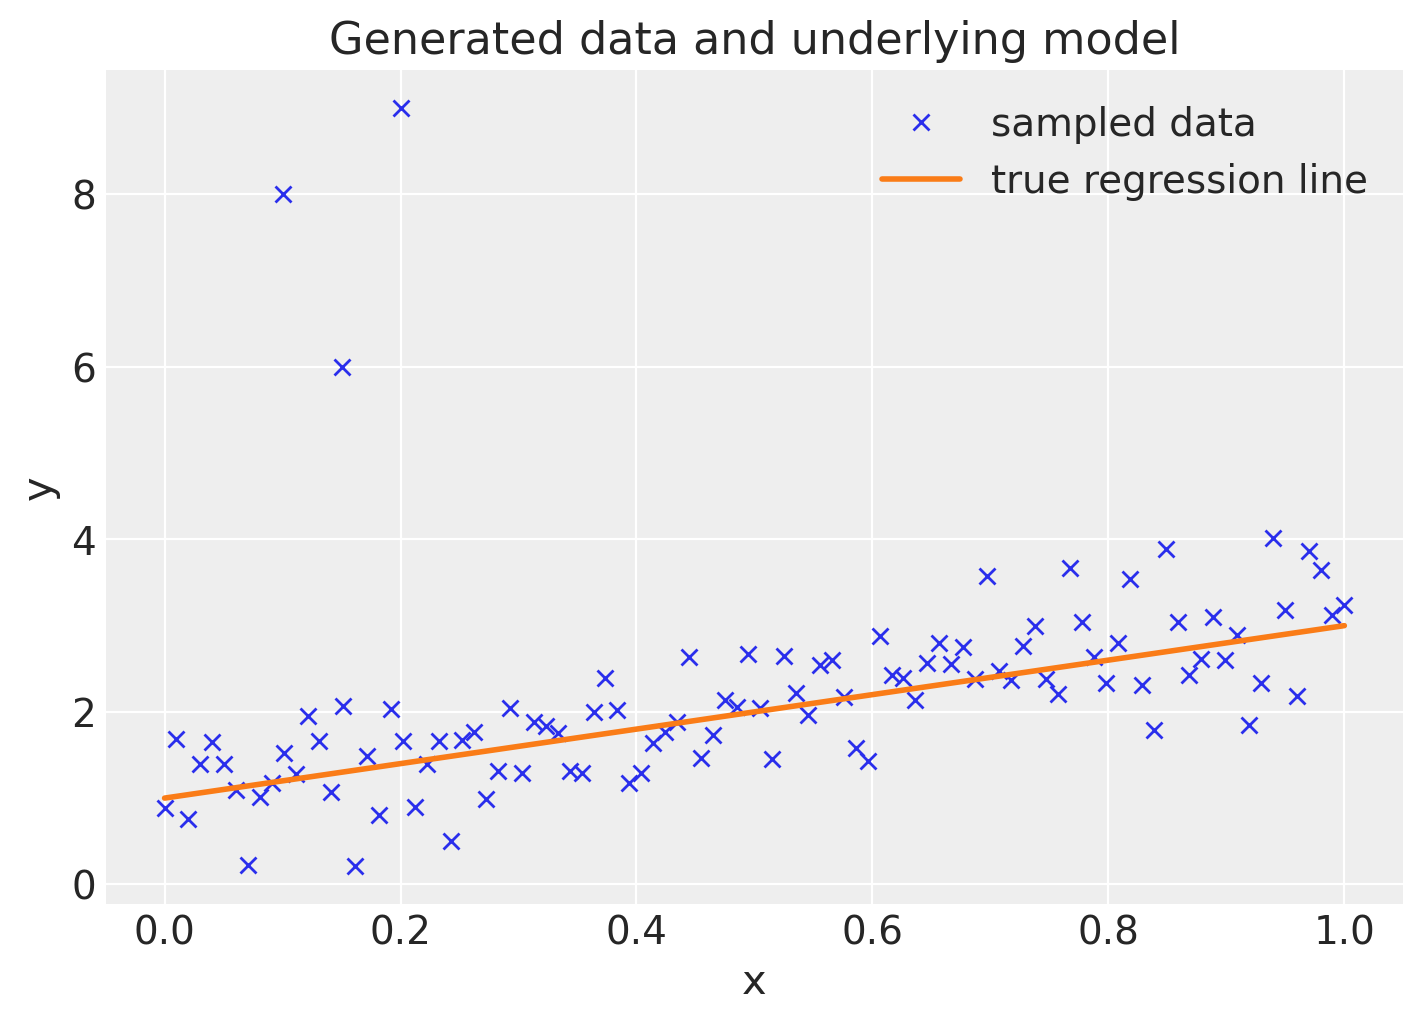

In [4]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Robust Regression

### Normal Likelihood

Lets see what happens if we estimate our Bayesian linear regression model by fitting a regression model with a normal likelihood. Note that the bambi library provides an easy to use such that an equivalent model can be built using one line of code. A version of this same notebook using Bambi is available at [bambi’s docs](https://bambinos.github.io/bambi/notebooks/t_regression.html)

In [5]:
with pm.Model() as model:
    xdata = pm.ConstantData("x", x_out, dims="obs_id")

    # define priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = pm.Deterministic("mu", intercept + slope * xdata, dims="obs_id")

    # define likelihood
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_out, dims="obs_id")

    # inference
    trace = pm.sample(tune=2000)

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 27 seconds.


To evaluate the fit, the code below calculates the posterior predictive regression lines by taking regression parameters from the posterior distribution and plots a regression line for 20 of them.

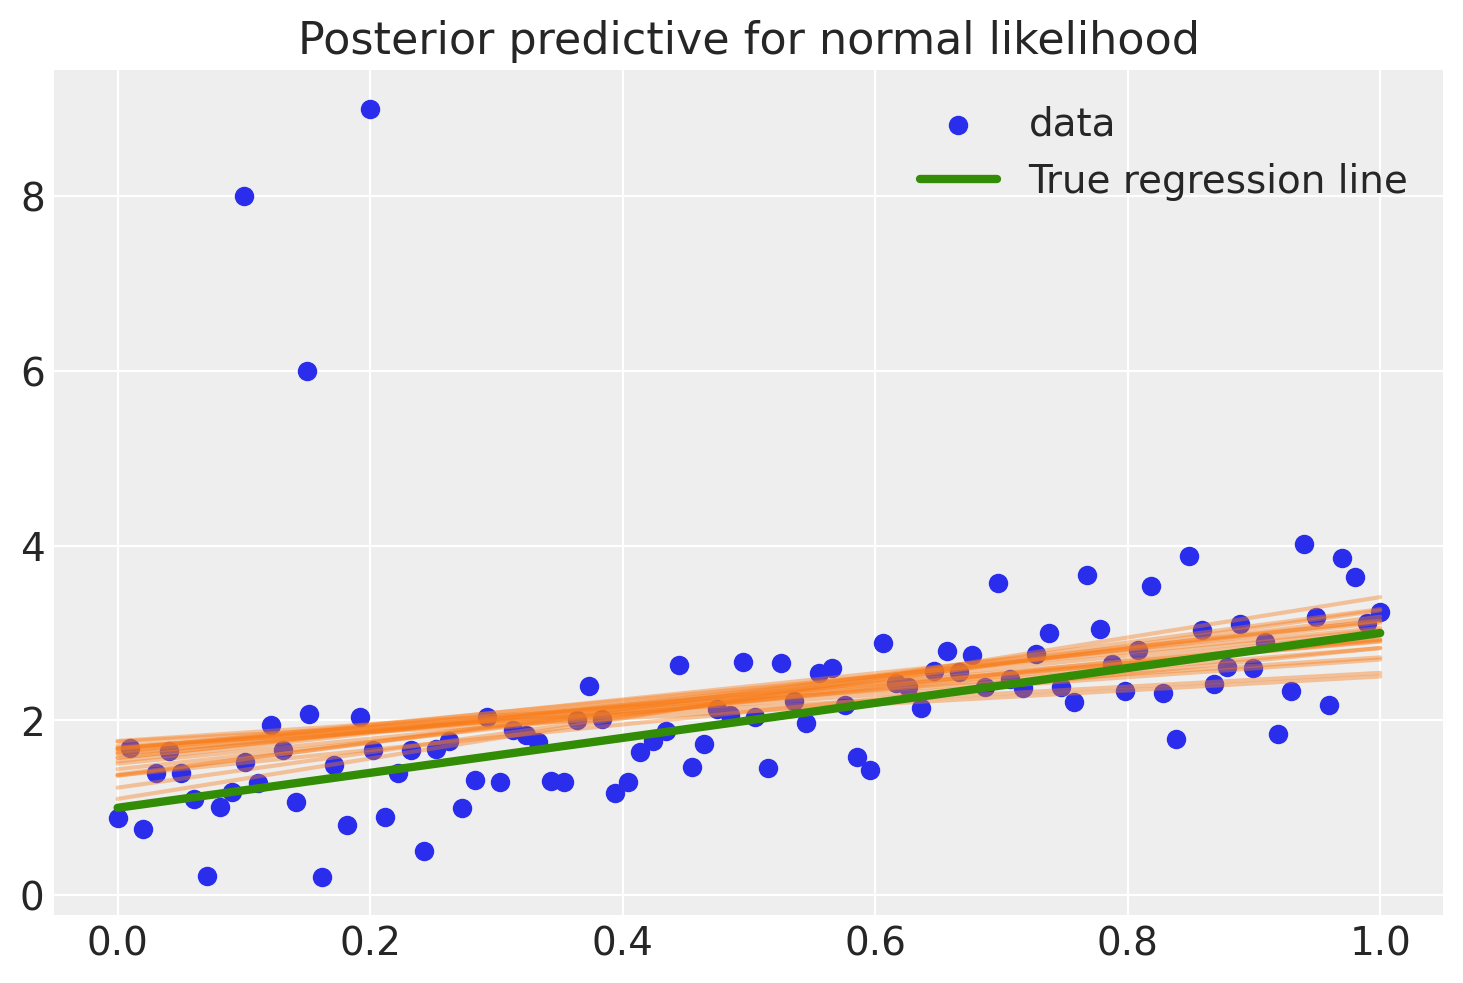

In [6]:
post = az.extract(trace, num_samples=20)
x_plot = xr.DataArray(np.linspace(x_out.min(), x_out.max(), 100), dims="plot_id")
lines = post["intercept"] + post["slope"] * x_plot

plt.scatter(x_out, y_out, label="data")
plt.plot(x_plot, lines.transpose(), alpha=0.4, color="C1")
plt.plot(x, true_regression_line, label="True regression line", lw=3.0, c="C2")
plt.legend(loc=0)
plt.title("Posterior predictive for normal likelihood");

As you can see, the fit is quite skewed and we have a fair amount of uncertainty in our estimate as indicated by the wide range of different posterior predictive regression lines. Why is this? The reason is that the normal distribution does not have a lot of mass in the tails and consequently, an outlier will affect the fit strongly.

A Frequentist would estimate a [Robust Regression](http://en.wikipedia.org/wiki/Robust_regression) and use a non-quadratic distance measure to evaluate the fit.

But what’s a Bayesian to do? Since the problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the [Student T distribution](http://en.wikipedia.org/wiki/Student%27s_t-distribution) which has heavier tails as shown next [[Kruschke, 2014](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#id56), [Gelman et al., 2013](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-truncated-censored-regression.html#id34)].

Lets look at those two distributions to get a feel for them.

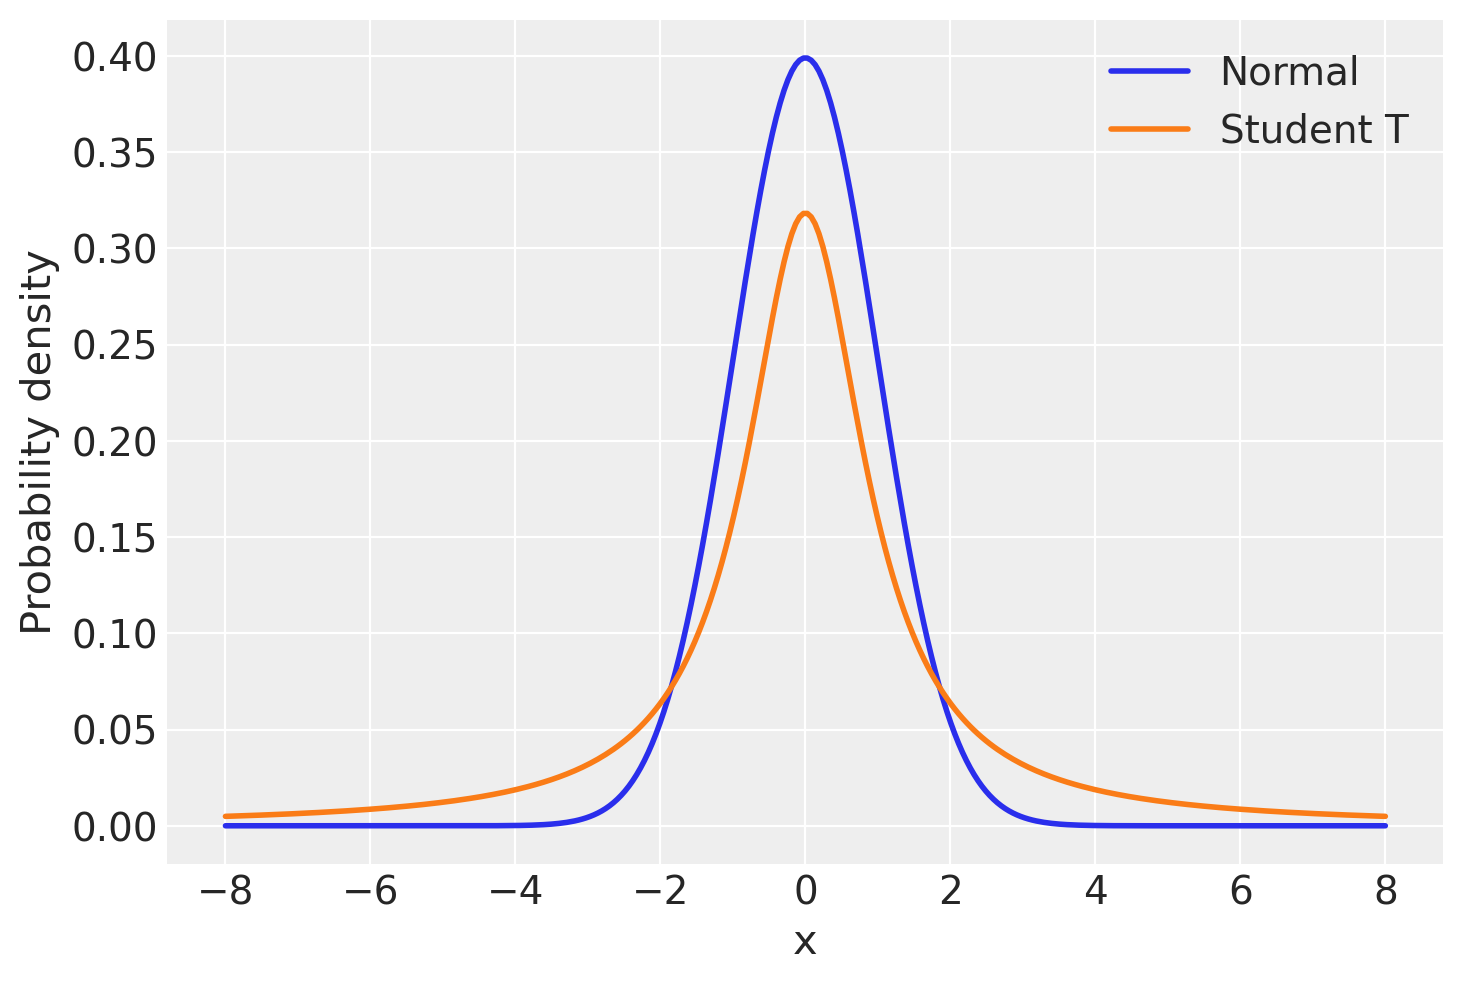

In [7]:
normal_dist = pm.Normal.dist(mu=0, sigma=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, pm.math.exp(pm.logp(normal_dist, x_eval)).eval(), label="Normal", lw=2.0)
plt.plot(x_eval, pm.math.exp(pm.logp(t_dist, x_eval)).eval(), label="Student T", lw=2.0)
plt.xlabel("x")
plt.ylabel("Probability density")
plt.legend();

As you can see, the probability of values far away from the mean (0 in this case) are much more likely under the ```T``` distribution than under the Normal distribution.

Below is a PyMC model, with the ```likelihood``` term following a ```StudentT``` distribution with $\nu = 3$
 degrees of freedom, opposed to the ```Normal``` distribution.

In [8]:
with pm.Model() as robust_model:
    xdata = pm.ConstantData("x", x_out, dims="obs_id")

    # define priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = pm.Deterministic("mu", intercept + slope * xdata, dims="obs_id")

    # define likelihood
    likelihood = pm.StudentT("y", mu=mu, sigma=sigma, nu=3, observed=y_out, dims="obs_id")

    # inference
    robust_trace = pm.sample(tune=4000)

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 30 seconds.


Text(0.5, 1.0, 'Posterior predictive for Student-T likelihood')

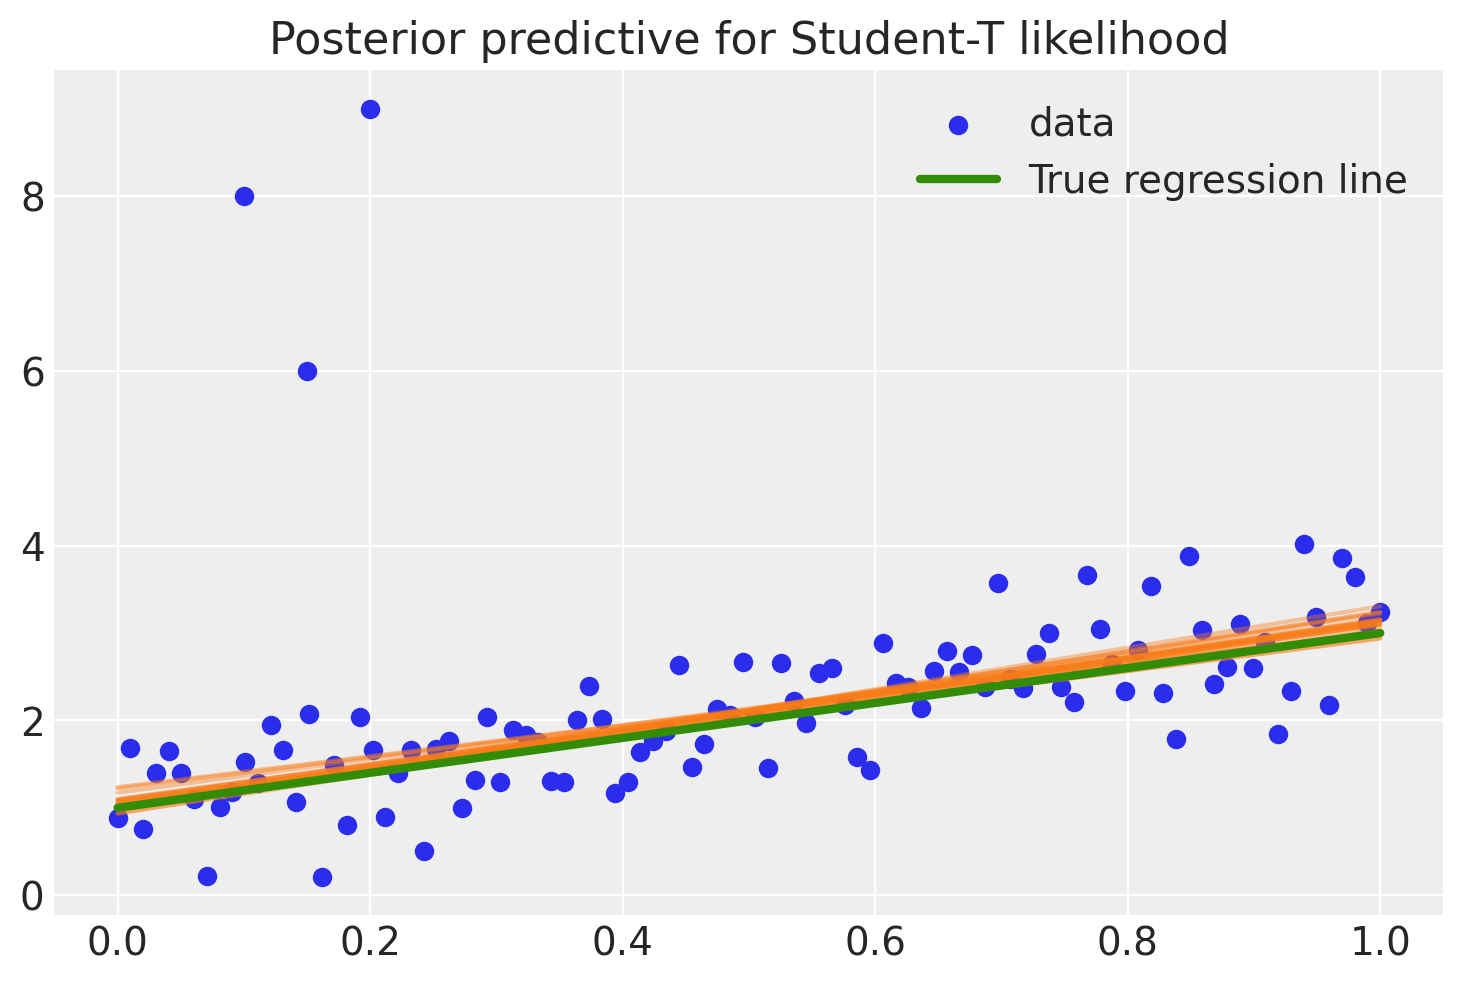

In [9]:
robust_post = az.extract(robust_trace, num_samples=20)
x_plot = xr.DataArray(np.linspace(x_out.min(), x_out.max(), 100), dims="plot_id")
robust_lines = robust_post["intercept"] + robust_post["slope"] * x_plot

plt.scatter(x_out, y_out, label="data")
plt.plot(x_plot, robust_lines.transpose(), alpha=0.4, color="C1")
plt.plot(x, true_regression_line, label="True regression line", lw=3.0, c="C2")
plt.legend(loc=0)
plt.title("Posterior predictive for Student-T likelihood")

There, much better! The outliers are barely influencing our estimation at all because our likelihood function assumes that outliers are much more probable than under the Normal distribution.

## Summary

* By changing the likelihood from a Normal distribution to a Student T distribution – which has more mass in the tails – we can perform Robust Regression.

Extensions:

* The Student-T distribution has, besides the mean and variance, a third parameter called degrees of freedom that describes how much mass should be put into the tails. Here it is set to 1 which gives maximum mass to the tails (setting this to infinity results in a Normal distribution!). One could easily place a prior on this rather than fixing it which I leave as an exercise for the reader ;).

* T distributions can be used as priors as well. See [A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html#glm-hierarchical)

* How do we test if our data is normal or violates that assumption in an important way? Check out this great blog post, [Probably Overthinking It](http://allendowney.blogspot.com/2013/08/are-my-data-normal.html), by Allen Downey.

## Authors

* Adapted from Thomas Wiecki’s blog
* Updated by @fonnesbeck in September 2016 (pymc#1378)
* Updated by @chiral-carbon in August 2021 (pymc-examples#205)
* Updated by Conor Hassan, Igor Kuvychko, Reshama Shaikh and Oriol Abril Pla in 2022
* Rerun using PyMC v5, by Reshama Shaikh, January 2023

## References

1. John Kruschke. Doing Bayesian data analysis: A tutorial with R, JAGS, and Stan. Academic Press, 2014.
1. Andrew Gelman, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin. Bayesian Data Analysis. Chapman and Hall/CRC, 2013.

## Watermark

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Tue Jun 11 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

xarray: 2024.3.0

pymc      : 5.13.1
numpy     : 1.26.4
matplotlib: 3.8.4
arviz     : 0.18.0
pytensor  : 2.20.0
pandas    : 2.2.2
xarray    : 2024.3.0

Watermark: 2.4.3



## License notice

All the notebooks in this example gallery are provided under the [MIT License](https://github.com/pymc-devs/pymc-examples/blob/main/LICENSE) which allows modification, and redistribution for any use provided the copyright and license notices are preserved.

## Citing PyMC examples

To cite this notebook, use the DOI provided by Zenodo for the pymc-examples repository.

Important

Many notebooks are adapted from other sources: blogs, books… In such cases you should cite the original source as well.

Also remember to cite the relevant libraries used by your code.

Here is an citation template in bibtex:

```py
@incollection{citekey,
  author    = "<notebook authors, see above>",
  title     = "<notebook title>",
  editor    = "PyMC Team",
  booktitle = "PyMC examples",
  doi       = "10.5281/zenodo.5654871"
}
```
which once rendered could look like:

Thomas Wiecki , Chris Fonnesbeck , Abhipsha Das , Conor Hassan , Igor Kuvychko , Reshama Shaikh , Oriol Abril Pla . "GLM: Robust Linear Regression". In: PyMC Examples. Ed. by PyMC Team. DOI: 10.5281/zenodo.5654871